<a href="https://colab.research.google.com/github/YuriiKlim/Projects/blob/Clothing_Classifier/clothing_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import sys
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from urllib.request import urlopen
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import requests
from concurrent.futures import ThreadPoolExecutor
import random

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'


device = "cuda" if torch.cuda.is_available() else "cpu"
#torch.set_default_device(device)

torch.manual_seed(0)

In [3]:
df = pd.read_csv('C:/Users/klimk/Desktop/Nike/NikeOnly.csv')
df

,sku,Type,Color,Gender,Brand
0,DX6482-500,Sneakers,Purple,Women,Nike
1,FZ3088-100,Sneakers,White,Women,Nike
2,DM8974-401,Sneakers,Turquoise,Women,Nike
3,DV3950-105,Sneakers,Beige,Women,Nike
4,FD2292-102,Sneakers,White,Women,Nike
...,...,...,...,...,...
16309,DX1023-010,Tank Top,Black,Women,Nike
16310,FB8281-010,Tank Top,Black,Women,Nike
16311,FB4629-821,Tank Top,Yellow,Women,Air Jordan
16312,FB7986-457,Tank Top,Blue,Women,Nike


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16314 entries, 0 to 16313
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sku     16314 non-null  object
 1   Type    16314 non-null  object
 2   Color   16312 non-null  object
 3   Gender  16314 non-null  object
 4   Brand   16314 non-null  object
dtypes: object(5)
memory usage: 637.4+ KB


In [5]:
type_counts = df['Type'].value_counts()
type_counts

Type
T-shirt              3063
Sneakers             2241
Shorts               1730
Hoodie               1430
Pants                1425
Longsleeve           1309
Tank Top              987
Jacket                604
Sweatshirt            503
Sweater               472
Leggings              462
Polo                  419
Top                   345
Football Boots        298
Track Jacket          189
Full-zip Hoodie       187
Shirt                 119
Slippers              116
Football Sneakers      91
Skirt                  89
Vest                   87
Dress                  73
Puffer jacket          38
Parka                  37
Name: count, dtype: int64

In [6]:
type_counts = df['Color'].value_counts()
type_counts

Color
Black               3617
White               2172
Blue                1898
Grey                1437
Beige                868
                    ... 
Green/Pink             1
Pink/Beige             1
Brown/Olive            1
Yellow/Turquoise       1
Light-Blue/Grey        1
Name: count, Length: 189, dtype: int64

In [7]:
data_dir = 'C:/Users/klimk/Desktop/Nike/main'

def load_image(file_name):
    file_path = os.path.join(data_dir, file_name + '.jpg')
    if os.path.exists(file_path):
        image = Image.open(file_path)
        return image
    else:
        return None

In [8]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])

In [9]:
def process_image_generator(skus):
    for sku in skus:
        image = load_image(sku)
        if image is not None:
            image = transform(image)
            yield sku, image

In [10]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

all_valid_skus = []

batch_size = 512
total_batches = len(df['sku']) // batch_size + 1

with ThreadPoolExecutor(max_workers=8) as executor:
    for i in tqdm(range(0, len(df['sku']), batch_size), desc="Processing Batches", total=total_batches):
        batch_skus = df['sku'][i:i + batch_size]
        results = list(executor.map(process_image_generator, [batch_skus]))

        for result in results:
            for sku, image in result:
                all_valid_skus.append(sku)

df = df[df['sku'].isin(all_valid_skus)].reset_index(drop=True)

sku_count = df['sku'].count()
print(f"Total valid SKUs: {sku_count}")

Processing Batches: 100%|██████████████████████████████████████████████████████████████| 32/32 [02:07<00:00,  4.00s/it]

Total valid SKUs: 16230


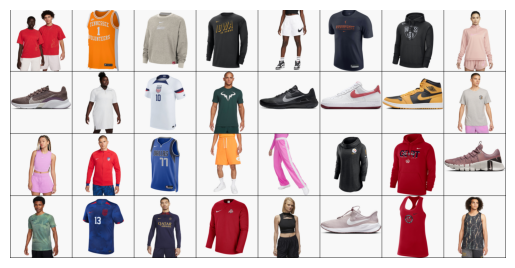

In [11]:
from torchvision.utils import make_grid

random_skus = random.sample(all_valid_skus, 32)

selected_images = [image for _, image in process_image_generator(random_skus)]

batch = torch.stack(selected_images)

grid = make_grid(batch).permute(1, 2, 0)

plt.imshow(grid)
plt.axis('off')
plt.show()

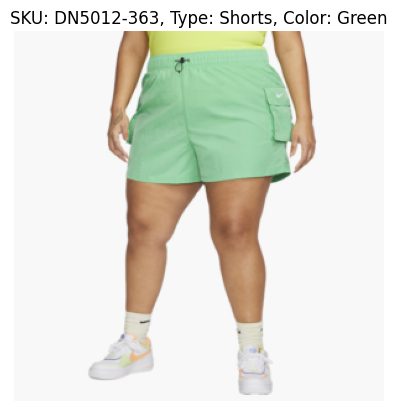

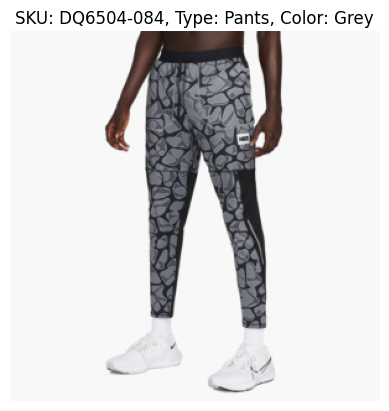

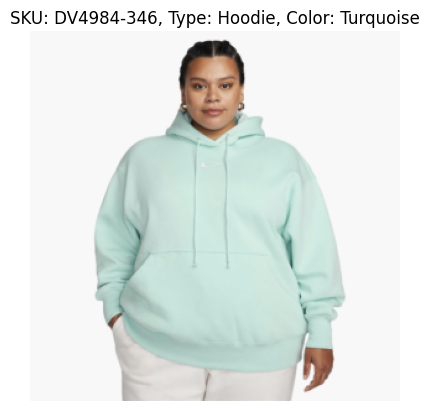

In [35]:
random_skus = random.sample(all_valid_skus, 3)

for sku in random_skus:
    for _, image in process_image_generator([sku]):
        img = image.numpy()
        img = img.transpose((1, 2, 0))

        label_name = df[df['sku'] == sku]['Type'].values[0]
        color_name = df[df['sku'] == sku]['Color'].values[0]

        plt.imshow(img)
        plt.title(f"SKU: {sku}, Type: {label_name}, Color: {color_name}")
        plt.axis('off')
        plt.show()

In [13]:
from sklearn.model_selection import train_test_split

train_ratio = 0.8

grouped = df.groupby('Type')

train_list = []
val_list = []

for _, group in grouped:
    train, val = train_test_split(group, test_size=1 - train_ratio, random_state=42)
    train_list.append(train)
    val_list.append(val)

train_data = pd.concat(train_list).reset_index(drop=True)
val_data = pd.concat(val_list).reset_index(drop=True)

print(f"Train data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")

Train data size: 12972
Validation data size: 3258


In [41]:
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm
import os

# Трансформації для навчальних і валідаційних даних (без ToTensor)
train_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[0.7950, 0.7757, 0.7759], std=[0.2544, 0.2742, 0.2743])
    # Normalize і інші необхідні трансформації, але без ToTensor
])

test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7950, 0.7757, 0.7759], std=[0.2544, 0.2742, 0.2743])
    # Normalize і інші необхідні трансформації, але без ToTensor
])


class TransformDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        sku = row['sku']
        img_path = os.path.join(data_dir, f"{sku}.jpg")
        image = load_image(sku)

        if self.transform:
            image = self.transform(image)

        label = row['Type']
        return image, label

# Створення датасетів для тренувальних та валідаційних даних
train_dataset = TransformDataset(train_data, transform=train_transform)
val_dataset = TransformDataset(val_data, transform=test_transform)

# Перевірка розміру датасетів
print(f"Train Dataset size: {len(train_dataset)}")
print(f"Validation Dataset size: {len(val_dataset)}")

Train Dataset size: 12972
Validation Dataset size: 3258


In [42]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size)

In [43]:
def convert_to_rgb(image_path):
    image = Image.open(image_path)
    if image.mode != 'RGB':
        image = image.convert('RGB')
        image.save(image_path)  # Зберігаємо зображення після конвертації
    return image

# Конвертація тренувальних зображень
print("Конвертація тренувальних зображень у 3-канальні (RGB):")
for idx, row in tqdm(train_data.iterrows(), total=len(train_data)):
    sku = row['sku']
    img_path = os.path.join(data_dir, f"{sku}.jpg")
    convert_to_rgb(img_path)

# Конвертація валідаційних зображень
print("Конвертація валідаційних зображень у 3-канальні (RGB):")
for idx, row in tqdm(val_data.iterrows(), total=len(val_data)):
    sku = row['sku']
    img_path = os.path.join(data_dir, f"{sku}.jpg")
    convert_to_rgb(img_path)

Конвертація тренувальних зображень у 3-канальні (RGB):


100%|██████████████████████████████████████████████████████████████████████████| 12972/12972 [00:04<00:00, 2674.99it/s]


Конвертація валідаційних зображень у 3-канальні (RGB):


100%|████████████████████████████████████████████████████████████████████████████| 3258/3258 [00:01<00:00, 2712.53it/s]


In [44]:
means = []
stds = []

print("Обчислення середніх значень і стандартних відхилень для нормалізації:")
for idx, (img, _) in enumerate(tqdm(val_dataset, desc="Calculating mean/std")):
    # Перевіряємо, що зображення має три канали
    if img.shape[0] == 3:  # RGB зображення мають 3 канали
        means.append(torch.mean(img, dim=[1, 2]).tolist())
        stds.append(torch.std(img, dim=[1, 2]).tolist())
    else:
        # Виведення назви зображення з некоректною кількістю каналів
        filename = val_data.iloc[idx]['sku']
        print(f"Зображення {filename} має некоректну кількість каналів: {img.shape[0]}")

# Обчислення середнього значення і стандартного відхилення для всіх зображень
mean = torch.mean(torch.tensor(means), dim=0)
std = torch.mean(torch.tensor(stds), dim=0)

mean, std

Обчислення середніх значень і стандартних відхилень для нормалізації:


Calculating mean/std: 100%|███████████████████████████████████████████████████████| 3258/3258 [00:32<00:00, 101.09it/s]


(tensor([1.4252e-04, 3.0965e-05, 1.5263e-04]),
 tensor([1.0002, 1.0000, 1.0000]))